# BDTT Task 2: Recommender System

## Introduction

In this task,  I will use MLlib to train a collaborative filtering recommender system using a dataset from Steam, an online videogame distribution service. The dataset contains details of which games members have purchased and how long they played their games, in hours. I will use this data to train an Alternating Least Squares (ALS) model to generate recommendations. I will evaluate the performance of the model using the Root Mean Square Error (RMSE) metric and improve the model using a grid search to tune the hyperparameters. 

**Note the gridsearches in cells 67 and 75 take up to 20 minutes each to run.**

## Data Import and Preprocessing

I imported the dataset from a csv file into a dataframe. There were 200,000 rows in the dataframe and no null values. There were 707 duplicate rows, all of which concerned the purchase data, not the play duration data. I deleted these duplicates. I added a column to my dataframe containing unique integer IDs for the videogames. This is because the ALS model requires integer inputs and the videogame names provided are strings, not integers. I then split the dataframe into two: one for purchase data and one for play duration data.

In [0]:
# Check csv file successfully uploaded into DBFS
dbutils.fs.ls("/FileStore/tables/steam_200k.csv")

[FileInfo(path='dbfs:/FileStore/tables/steam_200k.csv', name='steam_200k.csv', size=8059447, modificationTime=1743156953000)]

In [0]:
# Inspect structure of csv file
for line in dbutils.fs.head("/FileStore/tables/steam_200k.csv").splitlines():
    print(line.find(","))
    print(line)

[Truncated to first 65536 bytes]
9
151603712,The Elder Scrolls V Skyrim,purchase,1
9
151603712,The Elder Scrolls V Skyrim,play,273
9
151603712,Fallout 4,purchase,1
9
151603712,Fallout 4,play,87
9
151603712,Spore,purchase,1
9
151603712,Spore,play,14.9
9
151603712,Fallout New Vegas,purchase,1
9
151603712,Fallout New Vegas,play,12.1
9
151603712,Left 4 Dead 2,purchase,1
9
151603712,Left 4 Dead 2,play,8.9
9
151603712,HuniePop,purchase,1
9
151603712,HuniePop,play,8.5
9
151603712,Path of Exile,purchase,1
9
151603712,Path of Exile,play,8.1
9
151603712,Poly Bridge,purchase,1
9
151603712,Poly Bridge,play,7.5
9
151603712,Left 4 Dead,purchase,1
9
151603712,Left 4 Dead,play,3.3
9
151603712,Team Fortress 2,purchase,1
9
151603712,Team Fortress 2,play,2.8
9
151603712,Tomb Raider,purchase,1
9
151603712,Tomb Raider,play,2.5
9
151603712,The Banner Saga,purchase,1
9
151603712,The Banner Saga,play,2
9
151603712,Dead Island Epidemic,purchase,1
9
151603712,Dead Island Epidemic,play,1.4
9
151603712,BioShock I

In [0]:
# Create a dataframe from csv file. Include quote='"' to ensure game names with commas in them are not split across multiple columns 
df = spark.read.csv("/FileStore/tables/steam_200k.csv", header=False, inferSchema=True, quote='"').toDF("memberID", "game", "purchplay", "hours")
steamDF = df
steamDF.show(10, truncate = False)

+---------+--------------------------+---------+-----+
|memberID |game                      |purchplay|hours|
+---------+--------------------------+---------+-----+
|151603712|The Elder Scrolls V Skyrim|purchase |1.0  |
|151603712|The Elder Scrolls V Skyrim|play     |273.0|
|151603712|Fallout 4                 |purchase |1.0  |
|151603712|Fallout 4                 |play     |87.0 |
|151603712|Spore                     |purchase |1.0  |
|151603712|Spore                     |play     |14.9 |
|151603712|Fallout New Vegas         |purchase |1.0  |
|151603712|Fallout New Vegas         |play     |12.1 |
|151603712|Left 4 Dead 2             |purchase |1.0  |
|151603712|Left 4 Dead 2             |play     |8.9  |
+---------+--------------------------+---------+-----+
only showing top 10 rows



In [0]:
# Count the number of rows in my dataframe 
steamDF.count()

200000

From the code above, I can see there are 200,000 rows in my dataframe (steamDF). Next I will check for null values. 

In [0]:
# Check how many null values in each column
from pyspark.sql.functions import col, sum
steamDF.select([sum(col(c).isNull().cast("int")).alias(c) for c in steamDF.columns]).show()

+--------+----+---------+-----+
|memberID|game|purchplay|hours|
+--------+----+---------+-----+
|       0|   0|        0|    0|
+--------+----+---------+-----+



There are no null values in any of my columns. Next I will check for duplicate rows

In [0]:
# Check for duplicate rows
import pyspark.sql.functions as F

# Group the DataFrame by all columns, count the number of occurrences, and filter where the count is greater than 1
duplicates = steamDF.groupBy(steamDF.columns)\
    .count()\
    .where(F.col('count') > 1)

# Count number of rows that have been duplicated 
DupCount = duplicates.count()
print(DupCount)

707


The code above tells me there are 707 duplicate rows. I will inspect these more closely 

In [0]:
# Inspect top 20 duplicate rows
duplicates.show()

+---------+--------------------+---------+-----+-----+
| memberID|                game|purchplay|hours|count|
+---------+--------------------+---------+-----+-----+
|  9823354|Sid Meier's Civil...| purchase|  1.0|    2|
|  2259650|Sid Meier's Civil...| purchase|  1.0|    2|
| 56038151|Grand Theft Auto ...| purchase|  1.0|    2|
|142001340|Grand Theft Auto ...| purchase|  1.0|    2|
|152959594|Grand Theft Auto III| purchase|  1.0|    2|
| 50769696|Grand Theft Auto ...| purchase|  1.0|    2|
| 11813637|Sid Meier's Civil...| purchase|  1.0|    2|
| 65398650|Sid Meier's Civil...| purchase|  1.0|    2|
| 36502549|Sid Meier's Civil...| purchase|  1.0|    2|
| 80779496|Sid Meier's Civil...| purchase|  1.0|    2|
| 51557405|Grand Theft Auto ...| purchase|  1.0|    2|
|100351493|Sid Meier's Civil...| purchase|  1.0|    2|
|100351493|Sid Meier's Civil...| purchase|  1.0|    2|
|100351493|Sid Meier's Civil...| purchase|  1.0|    2|
|189858084|Grand Theft Auto ...| purchase|  1.0|    2|
| 69009454

From looking at 20 of the duplicate rows above, it would appear they are all of the 'purchase' type, not 'play' type. I will check this.

In [0]:
# Check how many duplicates are of 'play' records rather than 'purchase' records 
play_duplicates = duplicates.where(duplicates.purchplay=='play')
play_duplicates.count()

0

The code above confirms there are no duplicate rows which contain 'play' in the 'purchplay' column. This means the duplicates all concern the 'purchase' data. It could be that certain members have purchased certain games more than once, or these duplicates could simply be errors in the dataset. As it's not possible to tell, I will delete the duplicates to avoid the risk of distorting true preference strength and overfitting to repeated interractions. But first I will add a column containing an integer ID for each game (this will be necessary for training the recommender system, as the inputs need to be integers, not strings).

In [0]:
# Generate a unique integer ID for each game (gameID) and add this into the dataframe (steamDF)
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="game", outputCol="gameID")
steamDF_indexed = indexer.fit(steamDF).transform(steamDF)

steamDF_indexed.show(10, truncate = False)


🏃 View run dapper-shrimp-623 at: https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/d370526c42dc4d0989bd6e540b9e6e3a
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3435285711417728
+---------+--------------------------+---------+-----+------+
|memberID |game                      |purchplay|hours|gameID|
+---------+--------------------------+---------+-----+------+
|151603712|The Elder Scrolls V Skyrim|purchase |1.0  |8.0   |
|151603712|The Elder Scrolls V Skyrim|play     |273.0|8.0   |
|151603712|Fallout 4                 |purchase |1.0  |100.0 |
|151603712|Fallout 4                 |play     |87.0 |100.0 |
|151603712|Spore                     |purchase |1.0  |332.0 |
|151603712|Spore                     |play     |14.9 |332.0 |
|151603712|Fallout New Vegas         |purchase |1.0  |29.0  |
|151603712|Fallout New Vegas         |play     |12.1 |29.0  |
|151603712|Left 4 Dead 2             |purchase |1.0  |4.0   |
|151603712|Left 4 Dea

In [0]:
# Assign the original number of rows to a variable called 'OriginalCount' 
OriginalCount = steamDF_indexed.count()
print(OriginalCount)

200000


In [0]:
# Drop duplicates 
deduped_indexed_steamDF = steamDF_indexed.dropDuplicates(["memberID", "gameID", "purchplay", "hours"])
DedupedCount = deduped_indexed_steamDF.count()
print(DedupedCount)


199293


In [0]:
# Check the above code dropped the expected number of rows 
if OriginalCount - DupCount == DedupedCount:
    print("it worked")
else: 
    print("it didn't work")

it worked



### Creating 'purchase' and 'play' dataframes 
I created 2 versions of the dataframe: one containing only 'purchase' rows and one containing only 'play' rows. This will help with my exploratory data analysis (EDA) and model training below.

In [0]:
# Split dataframe into 2 dataframes: one for 'purchase' rows and one for 'play' rows 

# Import required modules 
from pyspark.sql import SparkSession 

# Create a SparkSession 
spark = SparkSession.builder.appName("Split DataFrame").getOrCreate() 

# Split the DataFrame into two 
purchase_df = deduped_indexed_steamDF.filter(deduped_indexed_steamDF['purchplay'] == 'purchase') 
play_df = deduped_indexed_steamDF.filter(deduped_indexed_steamDF['purchplay'] == 'play') 

# Print the new dataframes 
purchase_df.show(5, truncate=False) 
play_df.show(5, truncate=False)


+--------+----------------------+---------+-----+------+
|memberID|game                  |purchplay|hours|gameID|
+--------+----------------------+---------+-----+------+
|5250    |Dota 2                |purchase |1.0  |0.0   |
|5250    |Team Fortress 2       |purchase |1.0  |1.0   |
|5250    |Counter-Strike        |purchase |1.0  |6.0   |
|5250    |Half-Life 2 Deathmatch|purchase |1.0  |13.0  |
|5250    |Portal 2              |purchase |1.0  |15.0  |
+--------+----------------------+---------+-----+------+
only showing top 5 rows

+--------+-------------------------------+---------+-----+------+
|memberID|game                           |purchplay|hours|gameID|
+--------+-------------------------------+---------+-----+------+
|5250    |Dota 2                         |play     |0.2  |0.0   |
|5250    |Deus Ex Human Revolution       |play     |62.0 |118.0 |
|76767   |Counter-Strike Global Offensive|play     |3.5  |2.0   |
|76767   |Counter-Strike Source          |play     |25.0 |5.0   |


In [0]:
# Check the number of rows in the two new dataframes equals number of rows in original dataframe
steamDF_rows = deduped_indexed_steamDF.count()
purchase_df_rows = purchase_df.count()
play_df_rows = play_df.count()

if purchase_df_rows + play_df_rows == steamDF_rows:
    print("it worked")
else: 
    print("it didn't work")

it worked


In [0]:
# Check all 'hours' values in purchase_df are equal to 1 (to check that none of the 'play duration' rows were inaccurately labelled as 'purchase')
purchase_df.groupBy("hours").count().display()

hours count 1.0 128804

In [0]:
# Drop the 'purchplay' column from both new dataframes and 'hours' column from purchase dataframe as they're no longer needed (and might slow down processing if kept in)
dropped_purchase_df = purchase_df.drop("purchplay").drop("hours")
dropped_play_df = play_df.drop("purchplay") 

dropped_purchase_df.show(5, truncate=False) 
dropped_play_df.show(5, truncate=False)

+--------+----------------------+------+
|memberID|game                  |gameID|
+--------+----------------------+------+
|5250    |Dota 2                |0.0   |
|5250    |Team Fortress 2       |1.0   |
|5250    |Counter-Strike        |6.0   |
|5250    |Half-Life 2 Deathmatch|13.0  |
|5250    |Portal 2              |15.0  |
+--------+----------------------+------+
only showing top 5 rows

+--------+-------------------------------+-----+------+
|memberID|game                           |hours|gameID|
+--------+-------------------------------+-----+------+
|5250    |Dota 2                         |0.2  |0.0   |
|5250    |Deus Ex Human Revolution       |62.0 |118.0 |
|76767   |Counter-Strike Global Offensive|3.5  |2.0   |
|76767   |Counter-Strike Source          |25.0 |5.0   |
|76767   |Counter-Strike                 |365.0|6.0   |
+--------+-------------------------------+-----+------+
only showing top 5 rows



In [0]:
dropped_purchase_df.count()

128804

In [0]:
dropped_play_df.count()

70489

From the last 2 lines of code, I can see that there are fewer rows in the 'play' dataframe than the 'purchase' dataframe. This is as I'd expect, as not all games that are purchased will necessarily be played. However, every game that is played must first have been purchased (so the 'play' set is a subset of the 'purchase' set). Lastly, I will check if there are any rows in the 'play' dataframe that conatin 0 hours or 1 hour of play. 

In [0]:
# Check if any rows in the play duration dataframe contain 0.0 hours of play 
zero_hours_count = dropped_play_df.filter(dropped_play_df.hours == 0.0).count()
print("Number of rows with 0.0 hours:", zero_hours_count)

Number of rows with 0.0 hours: 0


In [0]:
# Check if any rows in the play duration dataframe contain 1.0 hours of play
one_hour_count = dropped_play_df.filter(dropped_play_df.hours == 1.0).count()
print("Number of rows with 1.0 hours:", one_hour_count)

Number of rows with 1.0 hours: 1058


There are no rows in the play duration dataframe containing 0 hours of play, so I don't have to address data in this dataset on unplayed games. There are 1,058 rows that contain exactly 1.0 hour of play. For this reason, I will keep the 'puchase' and 'play duration' datasets separate. If I were to re-combine them and use them together, it would be difficult to tell if the '1' value refers to 'purchased' or '1 hour of play duration'. 

## Exploratory Data Analysis (EDA)

In this section, I explored the ranges and trends of my dataset. For example, I investigated which members purchased the most games, which games were most and least purchased, and which members and games had the longest and shortest play durations. Range in play duration will be important for informing how I train my recommender system since ALS models are most accurate when their numerical inputs are evenly distributed. If the play duration is highly skewed, the long play duration values could disproportionately influence the model. This could lead it to overemphasize heavy players and make less accurate predictions and recommendations. 

###EDA of purchase data 

In [0]:
# Check which members purchased the most games
member_purchase_df = dropped_purchase_df.groupBy("memberID").count().sort("count", ascending=False)


In [0]:
# Check highest 3 and lowest 3 values for games purchased by members. 
member_purchase_df.show(3)

member_purchase_df.tail(3)

+--------+-----+
|memberID|count|
+--------+-----+
|62990992| 1068|
|33865373|  776|
|30246419|  759|
+--------+-----+
only showing top 3 rows



[Row(memberID=251093449, count=1),
 Row(memberID=24817862, count=1),
 Row(memberID=207347046, count=1)]

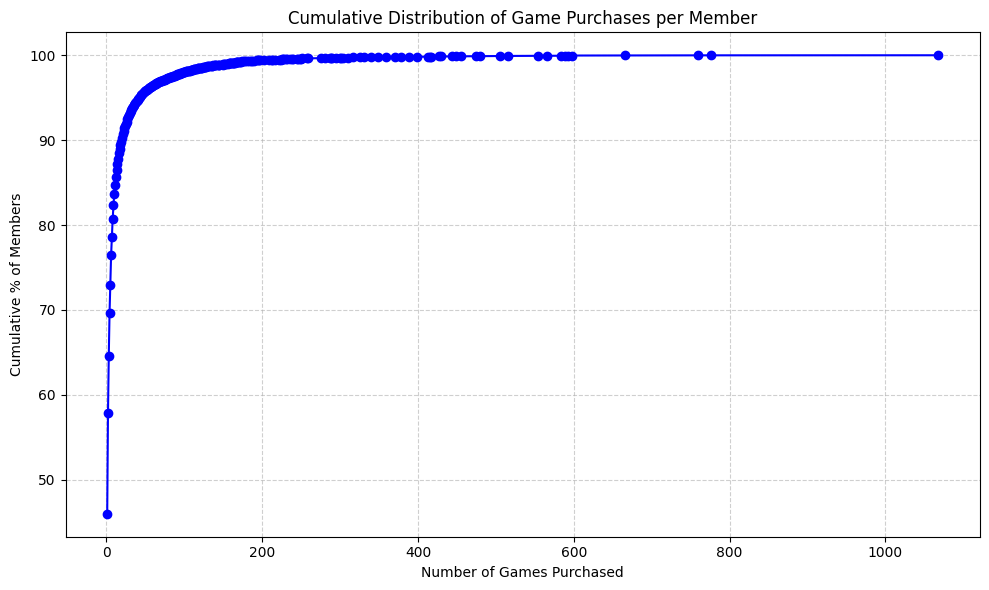

In [0]:
# Plot cumulative distribution curve of purchase data 

from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Group by the number of games purchased and count how many members fall into each group
grouped_df = member_purchase_df.groupBy("count").count().orderBy("count")

# Rename columns to avoid confusion
grouped_df = grouped_df.withColumnRenamed("count", "num_games") \
                       .withColumnRenamed("count_1", "num_members")

# Convert to Pandas and ensure column names are clean
purchase_pd = grouped_df.toPandas()
purchase_pd.columns = ["num_games", "num_members"]  # Reset any hidden duplicates

# Compute cumulative percentage
purchase_pd = purchase_pd.sort_values("num_games")
purchase_pd["cumulative_members"] = purchase_pd["num_members"].cumsum()
purchase_pd["cumulative_pct"] = purchase_pd["cumulative_members"] / purchase_pd["num_members"].sum() * 100

# Plot cumulative curve
plt.figure(figsize=(10,6))
plt.plot(purchase_pd["num_games"], purchase_pd["cumulative_pct"], marker="o", color="blue")
plt.xlabel("Number of Games Purchased")
plt.ylabel("Cumulative % of Members")
plt.title("Cumulative Distribution of Game Purchases per Member")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



From the plot above, I can see there is a wide range in the nubmer of games purchased by each member. Almost all members purchased 200 games or fewer, but there are quite a few outliers who purchased many more than 200 games. 
From the table, I can see the highest number of games purchased by an individual member is 1,068, followed by 776 and 759. The 3 lowest puchases were all 1 game per member. 

In [0]:
# Calculate mean number of games purchased 
mean_purchases = member_purchase_df.agg(F.mean("count")).first()[0]
print(f"Mean purchases per member: {round(mean_purchases, 0)}")


Mean purchases per member: 10.0


The mean number of purchases per member is 10 games. However, this is likely being skewed up by the large number of very high outliers (see cumulative distribution curve).

In [0]:
# Check which games are most and least purchased 
game_purchase_df = dropped_purchase_df.groupBy("game").count().sort("count", ascending=False).limit(10)

display(game_purchase_df)

game count Dota 2 4841 Team Fortress 2 2323 Unturned 1563 Counter-Strike Global Offensive 1412 Half-Life 2 Lost Coast 981 Counter-Strike Source 978 Left 4 Dead 2 951 Counter-Strike 856 Warframe 847 Half-Life 2 Deathmatch 823

Databricks visualization. Run in Databricks to view.

In [0]:
# Check 3 most purchased games and 3 least purchased games  
game_purchase_df.show(3)

game_purchase_df.tail(3)

+---------------+-----+
|           game|count|
+---------------+-----+
|         Dota 2| 4841|
|Team Fortress 2| 2323|
|       Unturned| 1563|
+---------------+-----+
only showing top 3 rows



[Row(game='Counter-Strike', count=856),
 Row(game='Warframe', count=847),
 Row(game='Half-Life 2 Deathmatch', count=823)]

From the bar chart above, we can see the most purchased game (Dota 2) has a far higher number of purchases (4,841) than the next 9 most-purchased games. The 3 least-purchased games still had quite high purchase counts (856, 847 and 823). 

### EDA of play duration data

In [0]:
# Check which members and games have the longest play times
dropped_play_df.orderBy("hours", ascending=False).display()

memberID game hours gameID 73017395 Sid Meier's Civilization V 11754.0 11.0 100630947 Dota 2 10442.0 0.0 153382649 Team Fortress 2 9640.0 1.0 130882834 Dota 2 7765.0 0.0 52567955 Dota 2 6964.0 0.0 121199670 Dota 2 6753.0 0.0 86256882 Dota 2 6015.0 0.0 70487610 Sid Meier's Civilization V 6013.0 11.0 101414179 Dota 2 5982.0 0.0 12660489 Dota 2 5970.0 0.0 95758079 Dota 2 5866.0 0.0 93950791 Sid Meier's Civilization V 5720.0 11.0 67694595 Dota 2 5608.0 0.0 106099216 Sid Meier's Civilization V 5483.0 11.0 117106617 Dota 2 5229.0 0.0 98308239 Dota 2 5142.0 0.0 128065805 Sid Meier's Civilization V 5002.0 11.0 20207081 Dota 2 4845.0 0.0 167194020 FINAL FANTASY XIV A Realm Reborn 4835.0 805.0 32749624 Counter-Strike 4814.0 6.0 102376253 Dota 2 4785.0 0.0 145606876 Football Manager 2014 4775.0 262.0 63615483 APB Reloaded 4749.0 78.0 120725727 Dota 2 4694.0 0.0 49312497 Counter-Strike Source 4676.0 5.0 22283916 Counter-Strike 4664.0 6.0 135879753 Counter-Strike Global Offensive 4659.0 2.0 125912054 Dota 2 4617.0 0.0 164643993 Dota 2 4462.0 0.0 57905818 Counter-Strike Source 4405.0 5.0 50811344 Dota 2 4335.0 0.0 133719158 Dota 2 4320.0 0.0 155182551 Dota 2 4228.0 0.0 121900241 Counter-Strike 4217.0 6.0 126388107 Dota 2 4122.0 0.0 137222368 Dota 2 4074.0 0.0 141706846 Dota 2 4067.0 0.0 125017535 Counter-Strike Global Offensive 4021.0 2.0 88290913 Dota 2 3940.0 0.0 52731290 Baldur's Gate II Enhanced Edition 3898.0 1243.0 41719717 Counter-Strike 3840.0 6.0 108315158 Dota 2 3790.0 0.0 113444723 Dota 2 3744.0 0.0 92914917 Dota 2 3738.0 0.0 58481977 Dota 2 3735.0 0.0 103804924 Dota 2 3704.0 0.0 105586920 Dota 2 3695.0 0.0 133024750 Dota 2 3692.0 0.0 98839983 Dota 2 3672.0 0.0 119937035 Garry's Mod 3667.0 7.0 43684632 Counter-Strike Global Offensive 3626.0 2.0 120852852 Dota 2 3590.0 0.0 64060101 Dota 2 3539.0 0.0 17017968 Team Fortress 2 3503.0 1.0 127461395 Dota 2 3481.0 0.0 156946266 Dota 2 3458.0 0.0 37422528 Counter-Strike Global Offensive 3416.0 2.0 139673932 Football Manager 2013 3374.0 189.0 66403743 Counter-Strike 3368.0 6.0 87740709 Dota 2 3356.0 0.0 103563010 Dota 2 3353.0 0.0 99077905 Dota 2 3309.0 0.0 92593907 Dota 2 3289.0 0.0 53244117 Counter-Strike 3283.0 6.0 111362598 Dota 2 3252.0 0.0 48798067 Mount & Blade Warband 3178.0 153.0 71871620 Counter-Strike 3169.0 6.0 172105480 Dota 2 3116.0 0.0 111551727 Dota 2 3085.0 0.0 114112364 Dota 2 3047.0 0.0 23492094 Dota 2 3038.0 0.0 57433226 Counter-Strike Source 3013.0 5.0 155069128 Dota 2 3010.0 0.0 117488479 Dota 2 2989.0 0.0 113423671 Dota 2 2979.0 0.0 49380630 Counter-Strike Source 2965.0 5.0 125141344 Team Fortress 2 2956.0 1.0 53964834 Counter-Strike 2903.0 6.0 190754099 Dota 2 2891.0 0.0 47291376 Counter-Strike 2889.0 6.0 161444156 Dota 2 2865.0 0.0 58223726 Counter-Strike 2857.0 6.0 109393227 Dota 2 2857.0 0.0 59662830 Dota 2 2852.0 0.0 142489812 Europa Universalis IV 2836.0 401.0 144532046 Dota 2 2758.0 0.0 86912006 Dota 2 2755.0 0.0 158693714 Dota 2 2741.0 0.0 38317154 Dota 2 2730.0 0.0 12195913 Left 4 Dead 2 2710.0 4.0 169560266 Dota 2 2700.0 0.0 157314597 Dota 2 2691.0 0.0 136783755 Dota 2 2682.0 0.0 173846745 Dota 2 2672.0 0.0 125324040 Dota 2 2666.0 0.0 30036927 Team Fortress 2 2653.0 1.0 155673786 Dota 2 2653.0 0.0 82263745 Dota 2 2634.0 0.0 47887890 Counter-Strike Source 2633.0 5.0 52731290 Baldur's Gate Enhanced Edition 2630.0 744.0 61189155 Dota 2 2623.0 0.0 112647787 Dota 2 2609.0 0.0 41606445 Counter-Strike 2605.0 6.0 54916182 Football Manager 2010 2603.0 555.0 148928721 Dota 2 2594.0 0.0 72329360 Sid Meier's Civilization V 2589.0 11.0 101487265 Dota 2 2582.0 0.0 16080105 Counter-Strike 2571.0 6.0 143137329 Dota 2 2566.0 0.0 46637811 Dota 2 2563.0 0.0 127074858 Dota 2 2531.0 0.0 78799565 Counter-Strike 2526.0 6.0 122679931 Team Fortress 2 2522.0 1.0 57433226 Counter-Strike Global Offensive 2508.0 2.0 10302000 Football Manager 2015 2503.0 265.0 153156310 Dota 2 2496.0 0.0 100519466 Arma 3 2484.0 110.0 48984158 Dota 2 2458.0 0.0 11403772 Dota 2 2443.0 0.0 121352371 Dota 

In [0]:
# See which member played the most hours across all games
member_play_df = dropped_play_df.drop("game").drop("gameID")

from pyspark.sql import functions as F

# Group by 'memberID', sum the 'hours', and sort in descending order
aggregated_df = member_play_df.groupBy("memberID") \
                  .agg(F.round(F.sum("hours"),3).alias("total_hours")) \
                  .orderBy(F.desc("total_hours"))

# Show the result
display(aggregated_df)


memberID total_hours 73017395 11754.0 10599862 11651.7 100630947 10853.2 26762388 10470.1 153382649 9640.0 43684632 9546.3 48798067 9427.2 52731290 9417.6 42935819 8172.9 14544587 8137.1 52567955 7836.7 130882834 7801.9 57433226 7741.5 63615483 7190.4 47063596 7161.0 67694595 7152.1 17017968 7108.5 50818751 6929.9 49893565 6891.9 24721232 6887.0 99077905 6838.4 121199670 6827.2 42849279 6766.2 81054122 6470.0 32126281 6362.6 49312497 6356.0 70487610 6325.5 86256882 6312.7 50811344 6171.3 43955374 6094.3 42657809 6093.4 12660489 6074.1 11403772 6009.9 101414179 5982.0 167194020 5930.0 95758079 5866.0 8585433 5856.6 17995238 5808.8 87201181 5792.4 34177747 5776.3 106099216 5739.8 62990992 5724.8 93950791 5720.0 57905818 5534.8 49380630 5525.9 32467994 5459.2 103260848 5419.3 42363887 5384.3 128065805 5366.0 23492094 5346.8 15415372 5331.7 20207081 5316.4 64392327 5301.0 120725727 5297.8 48525807 5260.0 112845094 5240.8 101596530 5232.8 117106617 5229.0 111362598 5205.3 131610144 5191.6 78799565 5186.9 98308239 5144.1 41719717 5128.6 59925638 5052.9 121900241 5038.8 43360645 5030.4 46637811 4958.6 32749624 4937.3 125912054 4923.6 145606876 4916.2 61189155 4894.7 113752996 4876.7 92593907 4855.2 10302000 4849.5 47457723 4844.3 135879753 4810.0 63157803 4801.2 102376253 4785.0 133024750 4771.6 66650717 4764.1 175001491 4729.6 82263745 4686.8 22283916 4681.7 26729643 4672.8 125017535 4635.3 37422528 4583.3 59662830 4563.7 101339059 4496.4 74347105 4496.3 92914917 4483.9 133719158 4474.7 164643993 4468.9 14465359 4405.5 24919113 4375.8 37723786 4370.2 117488479 4360.7 126388107 4340.0 137222368 4246.8 155182551 4228.0 44472980 4221.9 33651880 4219.5 47291376 4175.7 52321307 4118.5 62705916 4082.3 38049880 4076.5 38317154 4068.3 141706846 4067.0 40080833 4057.9 119937035 4053.6 88290913 4043.4 75368808 4019.1 127272741 4013.1 17649444 4001.9 11731710 3980.0 55906572 3960.6 86912006 3960.1 11373749 3943.2 7955670 3927.9 58481977 3923.6 105586920 3909.8 46951849 3882.0 111551727 3843.1 39037163 3826.6 65152385 3826.2 46030552 3819.6 30913209 3812.1 127461395 3795.0 108315158 3790.0 77214425 3785.8 103804924 3772.5 27279261 3762.2 113444723 3749.3 298950 3745.4 35701646 3699.3 87740709 3680.4 98839983 3672.0 252044076 3636.8 64060101 3625.9 33622085 3610.0 44545959 3602.6 120852852 3594.3 100519466 3584.3 87040683 3570.6 148362155 3568.8 60611062 3557.8 62078957 3520.5 79411077 3520.2 8776918 3508.8 56436338 3506.0 58761868 3499.7 103563010 3491.4 153156310 3490.3 139673932 3487.6 156946266 3485.4 103445207 3460.7 76032287 3453.5 94936385 3443.9 55975168 3382.2 66403743 3369.5 48984158 3346.3 86732465 3345.9 62878249 3291.7 53244117 3284.1 49767455 3271.9 71871620 3259.9 69856757 3232.9 59536273 3227.6 53898495 3227.3 36546868 3222.6 80511960 3214.9 173940259 3214.0 172105480 3212.4 14126086 3202.7 17567828 3200.9 23154676 3189.7 87071236 3180.6 113423671 3177.3 60608576 3175.2 66596291 3165.4 54826284 3161.2 96400571 3149.9 122679931 3134.1 43913966 3118.0 30519870 3101.3 144455775 3065.4 53711793 3062.8 121497634 3062.6 155673786 3061.7 122026623 3056.3 71510748 3049.9 13190476 3049.8 114112364 3047.0 99255590 3043.4 51822361 3035.2 121360145 3020.1 42005897 3013.4 138941587 3011.2 155069128 3010.0 47887890 3008.3 125141344 3008.2 92393218 2986.6 31669242 2976.5 58223726 2974.0 162288536 2973.1 137158399 2971.5 50797633 2948.7 190754099 2919.0 53964834 2903.0 11161178 2898.4 131940023 2895.2 161444156 2891.9 109393227 2889.0 151600301 2885.2 19696244 2883.1 118852041 2877.1 70778973 2859.3 124810250 2855.3 17530772 2845.6 165779930 2837.0 142489812 2836.0 12195913 2834.2 160427210 2826.2 124443679 2824.9 116876958 2824.3 11149819 2816.7 78309377 2815.8 80189887 2814.1 51085779 2807.5 80128229 2803.7 187463594 2800.1 36502549 2799.9 11813637 2799.1 80384872 2798.7 75598925 2796.6 104721942 2793.0 190191843 2773.7 126340495 2770.9 144532046 2766.2 63702300 2758.9 67713900 2748.6 72717958 2746.5 194970068 2744.5 158693714 2741.0 9823354 2

In [0]:
# Check memberIDs with 3 highest and 3 lowest play durations (across all games)
aggregated_df.show(3)
aggregated_df.tail(3)

+---------+-----------+
| memberID|total_hours|
+---------+-----------+
| 73017395|    11754.0|
| 10599862|    11651.7|
|100630947|    10853.2|
+---------+-----------+
only showing top 3 rows



[Row(memberID=289193172, total_hours=0.1),
 Row(memberID=74859759, total_hours=0.1),
 Row(memberID=28453247, total_hours=0.1)]

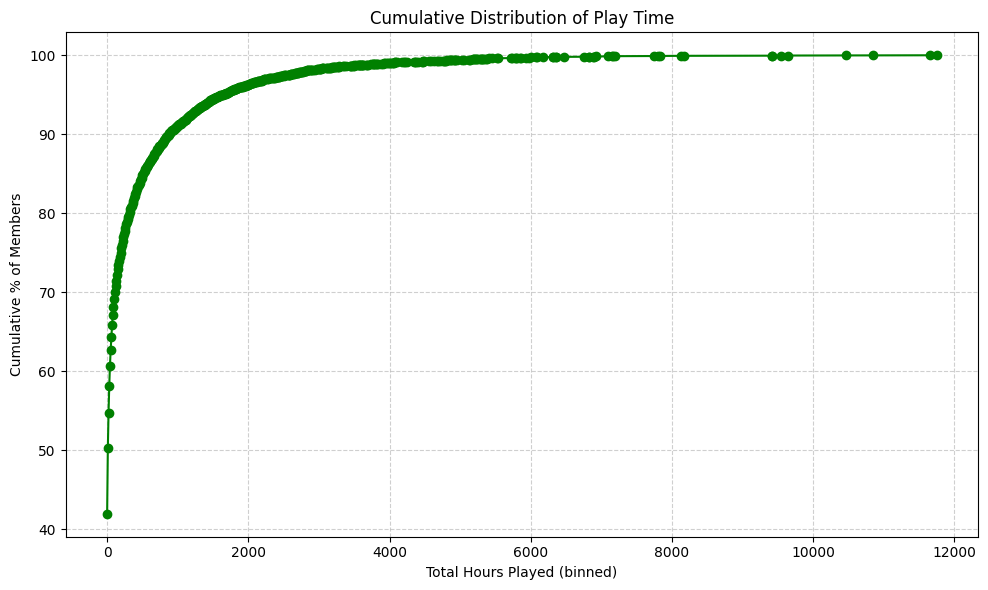

In [0]:
# Plot cumulative distribtion of play duration data 

from pyspark.sql.functions import floor, col

# Bin the total play hours into 10-hour buckets)
bucketed_df = aggregated_df.withColumn("hour_bin", floor(col("total_hours") / 10) * 10)

# Count how many members fall into each bin
cumulative_source_df = bucketed_df.groupBy("hour_bin").count().orderBy("hour_bin")

# Convert to pandas 
hist_pd = cumulative_source_df.toPandas().sort_values("hour_bin")
hist_pd["cumulative_members"] = hist_pd["count"].cumsum()
hist_pd["cumulative_pct"] = hist_pd["cumulative_members"] / hist_pd["count"].sum() * 100

# Plot curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(hist_pd["hour_bin"], hist_pd["cumulative_pct"], marker="o", color="green")
plt.xlabel("Total Hours Played (binned)")
plt.ylabel("Cumulative % of Members")
plt.title("Cumulative Distribution of Play Time")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()



The cumulative distribution curve above is similar to the purchase data: almost 100% of members played fewer than 4,000 hours across all games. However, a large number of outliers played more, up to 11,754 hours. 
This means there is very high variance in the hours column. This might cause problems for the recommender system I will build, since ALS models work best when numerical values are more evenly distributed and not so highly skewed. The ALS might overfit to members who have extremely high play durations, which will mean the predictions are not generalisable across members with lower play durations. 

In [0]:
# Calculate mean playing time 
mean_play_time = aggregated_df.agg(F.mean("total_hours")).first()[0]
print(f"Mean total play duration per member: {round(mean_play_time, 2)} hours")


Mean total play duration per member: 303.56 hours


The mean duration of play is 303.56 hours. However, this is likely skewed up by the outlies that played far more hours that most other members (see cumulative distribution chart above). 

In [0]:
# See which game was played the most hours across all members 

game_play_df = dropped_play_df.drop("memberID").drop("gameID")

# Group by 'game', sum the 'hours', and sort in descending order
aggregated_df2 = game_play_df.groupBy("game") \
                  .agg(F.round(F.sum("hours"),3).alias("total_hours")) \
                  .orderBy(F.desc("total_hours"))

# Show the result
aggregated_df2.display()

game total_hours Dota 2 981684.6 Counter-Strike Global Offensive 322771.6 Team Fortress 2 173673.3 Counter-Strike 134261.1 Sid Meier's Civilization V 99821.3 Counter-Strike Source 96075.5 The Elder Scrolls V Skyrim 70889.3 Garry's Mod 49725.3 Call of Duty Modern Warfare 2 - Multiplayer 42009.9 Left 4 Dead 2 33596.7 Football Manager 2013 32308.6 Football Manager 2012 30845.8 Football Manager 2014 30574.8 Terraria 29951.8 Warframe 27074.6 Football Manager 2015 24283.1 Arma 3 24055.7 Grand Theft Auto V 22956.7 Borderlands 2 22667.9 Empire Total War 21030.3 Total War ROME II - Emperor Edition 20892.5 Mount & Blade Warband 20636.8 Call of Duty Modern Warfare 3 - Multiplayer 20603.0 DayZ 20315.4 PAYDAY 2 19613.8 Call of Duty Black Ops - Multiplayer 17144.5 Unturned 16096.4 Total War SHOGUN 2 15761.5 Rust 15275.3 Fallout New Vegas 14832.9 War Thunder 14381.6 Call of Duty Black Ops II - Multiplayer 13816.3 ARK Survival Evolved 13593.1 Football Manager 2010 13126.7 Clicker Heroes 12937.4 Football Manager 2011 11336.8 Fallout 4 10762.8 Path of Exile 10185.6 Napoleon Total War 9966.0 Europa Universalis IV 9759.0 Arma 2 Operation Arrowhead 9429.7 APB Reloaded 9237.2 Portal 2 9117.1 Robocraft 9096.6 Crusader Kings II 9020.7 Left 4 Dead 8659.9 Call of Duty Modern Warfare 2 8635.4 Killing Floor 8171.1 Counter-Strike Condition Zero 7950.0 Rocket League 7827.2 XCOM Enemy Unknown 7696.1 Football Manager 2009 7434.4 H1Z1 7364.2 Euro Truck Simulator 2 7226.9 Torchlight II 6891.9 Age of Empires II HD Edition 6858.5 The Binding of Isaac Rebirth 6735.5 Battlefield Bad Company 2 6678.6 FINAL FANTASY XIV A Realm Reborn 6618.5 PlanetSide 2 6239.7 DARK SOULS II 6193.8 AdVenture Capitalist 6067.7 The Binding of Isaac 5458.1 Call of Duty Modern Warfare 3 5443.6 Rising Storm/Red Orchestra 2 Multiplayer 5412.5 Kerbal Space Program 5334.5 Starbound 5189.8 Far Cry 3 5076.0 Warhammer 40,000 Dawn of War II Retribution 4983.7 Saints Row The Third 4954.1 Tom Clancy's Ghost Recon Phantoms - NA 4910.8 The Witcher 3 Wild Hunt 4876.9 Day of Defeat Source 4840.3 Trove 4818.4 METAL GEAR SOLID V THE PHANTOM PAIN 4751.1 Borderlands 4742.8 Dark Souls Prepare to Die Edition 4738.5 Stronghold Kingdoms 4703.1 Grand Theft Auto IV 4686.3 DC Universe Online 4674.7 Space Engineers 4467.1 Baldur's Gate II Enhanced Edition 4277.3 Half-Life 2 4260.3 Sid Meier's Civilization IV Beyond the Sword 4201.4 Might & Magic Heroes VI 4139.5 7 Days to Die 4075.5 Chivalry Medieval Warfare 3964.4 Call of Duty Black Ops 3876.0 Dungeon Defenders 3816.2 Call of Duty Ghosts - Multiplayer 3804.6 Half-Life 2 Deathmatch 3712.9 BioShock Infinite 3689.1 Deus Ex Human Revolution 3587.4 Don't Starve 3581.9 Star Trek Online 3501.1 Just Cause 2 3457.5 Neverwinter 3451.5 Warhammer 40,000 Dawn of War II 3444.1 Heroes & Generals 3299.5 Medieval II Total War 3284.0 The Witcher Enhanced Edition 3257.5 The Witcher 2 Assassins of Kings Enhanced Edition 3254.3 Tom Clancy's Ghost Recon Phantoms - EU 3234.3 Assassin's Creed IV Black Flag 3230.3 Marvel Heroes 2015 3219.8 Cities Skylines 3201.2 Tomb Raider 3184.3 RIFT 3113.6 Call of Duty Advanced Warfare - Multiplayer 3096.4 Baldur's Gate Enhanced Edition 3094.9 Train Simulator 2975.5 Mafia II 2893.4 Borderlands The Pre-Sequel 2852.1 Dishonored 2842.2 Sid Meier's Civilization Beyond Earth 2826.6 NBA 2K15 2714.7 Total War ATTILA 2654.7 Banished 2631.0 Prison Architect 2626.5 Mass Effect 2609.8 Mortal Kombat X 2598.1 Call of Duty World at War 2583.5 Saints Row IV 2563.0 Dragon Age Origins - Ultimate Edition 2552.5 Assassin's Creed III 2545.4 Dead Island 2532.0 Pro Evolution Soccer 2015 2500.5 Natural Selection 2 2498.9 Mass Effect 2 2492.0 Elite Dangerous 2455.7 Zombie Panic Source 2440.7 Plants vs. Zombies Game of the Year 2427.6 Rome Total War 2396.6 TERA 2388.1 Divinity Original Sin 2380.1 Supreme Commander 2 2361.5 Spiral Knights 2360.7 Middle-earth Shadow of Mordor 2324.5 Insurgency 2317.1 FTL Faster Than Light 2315.8 Football Manager 2016 2296.6 Portal 2282.8 Trans

In [0]:
# Visualise how many hours the top 10 most-played games were played for 
aggregated_df2.limit(10)

display(aggregated_df2.limit(10))

game total_hours Dota 2 981684.6 Counter-Strike Global Offensive 322771.6 Team Fortress 2 173673.3 Counter-Strike 134261.1 Sid Meier's Civilization V 99821.3 Counter-Strike Source 96075.5 The Elder Scrolls V Skyrim 70889.3 Garry's Mod 49725.3 Call of Duty Modern Warfare 2 - Multiplayer 42009.9 Left 4 Dead 2 33596.7

Databricks visualization. Run in Databricks to view.

In [0]:
# Check games with 3 highest and 3 lowest play durations (across all members)
aggregated_df2.show(3)
aggregated_df2.tail(3)

+--------------------+-----------+
|                game|total_hours|
+--------------------+-----------+
|              Dota 2|   981684.6|
|Counter-Strike Gl...|   322771.6|
|     Team Fortress 2|   173673.3|
+--------------------+-----------+
only showing top 3 rows



[Row(game='Habitat', total_hours=0.1),
 Row(game='Sandmason', total_hours=0.1),
 Row(game='Quake Mission Pack 2 Dissolution of Eternity', total_hours=0.1)]

The code and chart above show there is a high variance in the duration of game play. The most-played game (Dota 2) was played for far more hours than the next 9 most-played games, as the bar chart shows. This matches the finding in the EDA of purchase data, which showed that Dota 2 was by far the most frequently purchased game. 

## Model training using play duration data 
In this section, I normalised the 'hours' column of the play duration dataframe I created at the end of the 'data import and pre-processing' section above. Then I split it into training and test sets. I then trained an Alternating Least Squares (ALS) algorithm on a training dataset using arbitrary hyperparameters and used it to generate predictions.

In [0]:
# Import mlflow and autolog machine learning runs to track experiments 
import mlflow
import logging 

# Adjust the logging level to suppress non-error messages from MLflow for cleaner output
logging.getLogger("mlflow").setLevel(logging.ERROR)
mlflow.pyspark.ml.autolog()

In [0]:
# Normalise 'hours' column using min-max normalisation. This is because in the original dataset, there is very high variance in this column (0.1 hours - 11,754 hours). Without normalisation, the ALS model might overfit to members who have extremely high playtimes. Normalisation smooths out differences, improving generalisation and accuracy.

from pyspark.sql.functions import col, max as spark_max

max_hours = dropped_play_df.agg(spark_max("hours")).collect()[0][0]
data = dropped_play_df.withColumn("normalised_hours", col("hours") / max_hours)


In [0]:
# Set up ALS model. I instantiated an instance of the estimator and specified the columns in the dataframe which are the userCol, itemCol and ratingCol. I set implicitPrefs = True because the model is being trained on play duration data, which is a form of implicit feedback. I set nonnegative=True because it would not make sense for predicted values to be negative numbers.

from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

play_als = ALS(
    userCol="memberID",
    itemCol="gameID",
    ratingCol="normalised_hours",
    implicitPrefs=True,
    coldStartStrategy="drop",  # drop NaN predictions
    rank=10,
    maxIter=5,
    regParam=0.1,
    seed=42
)

# Create training and test datasets
(training, test) = data.randomSplit([0.8, 0.2], seed=42)

# Cache and materialize the training set to reduce redundant computation
training.cache()
training.count()

56443

In [0]:
# Train model
play_model = play_als.fit(training)

# Generate predictions 
predictions = play_model.transform(test)

🏃 View run bedecked-seal-366 at: https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/9e5c0f587aa1467f8f3e671029a5f491
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3435285711417728


I can see above that MLFlow has logged this as a run. I've re-named this run [play_als_pre_tuning](https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/c146b43112664e95b69dafa529a21861?o=443721649673591)

In [0]:
# Examine predictions which are on the normalised scale (that is, to be compared with the 'normalised_hours' column, not the original 'hours' column). 
predictions.show(truncate=False)

+--------+-------------------------------------------------------+-----+------+---------------------+-----------+
|memberID|game                                                   |hours|gameID|normalised_hours     |prediction |
+--------+-------------------------------------------------------+-----+------+---------------------+-----------+
|76767   |Alien Swarm                                            |0.8  |32    |6.806193636208951E-5 |0.1131873  |
|76767   |Call of Duty Modern Warfare 3                          |15.9 |58    |0.0013527309851965289|0.31413686 |
|76767   |Counter-Strike                                         |365.0|6     |0.031053258465203334 |0.4394876  |
|86540   |Alan Wake                                              |0.2  |176   |1.7015484090522377E-5|0.06368169 |
|86540   |Torchlight II                                          |3.6  |65    |3.0627871362940275E-4|0.10658308 |
|229911  |Counter-Strike                                         |45.0 |6     |0.0038284

## Model evaluation
I evaluated the accuracy of the predictions generated by the ALS model above, as compared to the actual values in the test dataset, using the Root Mean Square Error (RMSE) metric. 

In [0]:
# Instantiate the evaluator
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="normalised_hours",
    predictionCol="prediction"
)

# Compute RMSE
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")


Root-mean-square error = 0.3011727367752308


The RMSE value is 0.30 (to 2 decimal places). This means the model's predictions are off by ±0.30 from the true values in the 'normalised hours' column. Since both the 'normalised_hours' and the 'prediction' values are in the range [0, 1], this means a 30% absolute error on average

## Hyperparameter tuning
In this section, I conducted a grid search to see if there are different hyperparameters that could be used to improve the accuracy of the ALS model 

In [0]:
# Set up parameter grid
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = (ParamGridBuilder()
    .addGrid(play_als.rank, [10, 15])
    .addGrid(play_als.regParam, [0.1, 0.2])
    .addGrid(play_als.alpha, [5.0, 10.0])
    .build())

In [0]:
# TrainValidationSplit setup
from pyspark.ml.tuning import TrainValidationSplit
    
tvs = TrainValidationSplit()\
    .setSeed(42)\
    .setTrainRatio(0.75)\
    .setEstimatorParamMaps(paramGrid)\
    .setEstimator(play_als)\
    .setEvaluator(evaluator)\
    .setParallelism(2)

In [0]:
# Fit model (NOTE this cell can take up to 20min to run)
tvs_play_model = tvs.fit(training)

🏃 View run likeable-croc-841 at: https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/920bcfd883bf45a0af2ac1ac26c3e6a5
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3435285711417728
🏃 View run trusting-skink-621 at: https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/28dd881eb2104ded92daddad0cb967a4
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3435285711417728
🏃 View run omniscient-lark-319 at: https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/a7c35b2d0fc6431aaec3d7d79d1d61b2
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3435285711417728
🏃 View run spiffy-gnu-13 at: https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/c2f38ee3df1a4c56b94f90ee0c8dd710
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3435285711417728
🏃 View run polite-rat-923 at: https://community.cloud.databri

I can see that MLFlow has logged 9 runs. This is because the grid search runs every combination of hyperparameters to find the combination that results in the most accurate (lowest) RMSE. I've re-named this set of runs [play_als_tuning_runs](https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/6c661f9a7971491eb3ddc254ef1aae05?o=443721649673591). The best hyperparameters and RMSE obtained from these runs can be seen in the MLflow log and are also printed below. 

In [0]:
# Print the optimal hyperparameters as determined by the grid search 
better_play_model = tvs_play_model.bestModel

print("Rank:", better_play_model.rank)
print("RegParam:", better_play_model._java_obj.parent().getRegParam())
print("Alpha:", better_play_model._java_obj.parent().getAlpha())


Rank: 10
RegParam: 0.2
Alpha: 5.0


In [0]:

# Make predictions using test set and compute RMSE
predictions = better_play_model.transform(test)
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

Root-mean-square error = 0.23954628643124343


The RMSE value following hyperparameter tuning is 0.24, which is lower and therefore more accurate than the RMSE obtained before hyperparameter tuning.

RMSE measures accuracy of predicted scores, but the purpose of recommender systems is to rank items correctly — not necessarily getting the exact score right. So even though the RMSE is 0.24, this model might still rank the right games at the top for each member and provide useful, personalized recommendations. 

## Model training using purchase data 
In this section, I split the purchase dataframe into training and test sets. I then trained an ALS algorithm on the training dataset, used a gridsearch for hyperparameter tuning and obtained an RMSE value. I then compared the RMSE to that of the ALS model above trained on play duration data to see which version is more accurate.

In [0]:
# Create a 'confidence' column (contains '1' to indicate game has been bought). This will be the column I use as the 'ratings' column when training the ALS model. 
from pyspark.sql.functions import lit

purchase_data = dropped_purchase_df.withColumn("confidence", lit(1.0))

purchase_data.show()

+--------+--------------------+------+----------+
|memberID|                game|gameID|confidence|
+--------+--------------------+------+----------+
|    5250|              Dota 2|   0.0|       1.0|
|    5250|     Team Fortress 2|   1.0|       1.0|
|    5250|      Counter-Strike|   6.0|       1.0|
|    5250|Half-Life 2 Death...|  13.0|       1.0|
|    5250|            Portal 2|  15.0|       1.0|
|    5250|         Half-Life 2|  16.0|       1.0|
|    5250|Half-Life 2 Episo...|  44.0|       1.0|
|    5250|           Half-Life|  45.0|       1.0|
|    5250|Half-Life Blue Shift|  74.0|       1.0|
|    5250|Deus Ex Human Rev...| 118.0|       1.0|
|    5250|     Cities Skylines| 158.0|       1.0|
|   76767|            Portal 2|  15.0|       1.0|
|   76767|  Deathmatch Classic|  34.0|       1.0|
|   76767|Call of Duty Mode...|  58.0|       1.0|
|   76767|              Arma 2|  70.0|       1.0|
|   76767|               Thief| 239.0|       1.0|
|   76767|Thief Deadly Shadows| 663.0|       1.0|


In [0]:
# Re-run the ALS model training and hyperparameter tuning using the purchase data instead of the play data 

(training, test) = purchase_data.randomSplit([0.8, 0.2], seed=42)
training.cache()
training.count()

purchase_als = ALS(
    userCol="memberID",
    itemCol="gameID",
    ratingCol="confidence",
    implicitPrefs=True,
    coldStartStrategy="drop",
    nonnegative=True
)

paramGrid = ParamGridBuilder() \
    .addGrid(purchase_als.rank, [5, 10]) \
    .addGrid(purchase_als.regParam, [0.1, 0.2]) \
    .addGrid(purchase_als.alpha, [5.0, 10.0]) \
    .build()

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="confidence",
    predictionCol="prediction"
)

tvs = TrainValidationSplit(
    estimator=purchase_als,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,
    parallelism=2
)

In [0]:
# Fit model on purchase training data (NOTE this cell can take 10-20min to run)
tvs_purchase_model = tvs.fit(training)

🏃 View run vaunted-wolf-88 at: https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/7dd9ca47414c4c27b5ed93373e307acf
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3435285711417728
🏃 View run amusing-rook-720 at: https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/e87400bd7f7346c1a75e2e6a5252638a
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3435285711417728
🏃 View run righteous-crow-351 at: https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/cb131c85e1774945a0f8bb724c7d7b86
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3435285711417728
🏃 View run masked-midge-378 at: https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/0345d0e826624ac3ad39fae75a232e61
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/3435285711417728
🏃 View run mercurial-ox-183 at: https://community.cloud.databri

As before, MLflow has logged 9 runs for the grid search. I've re-named this set of runs [purchase_als_tuning_runs](https://community.cloud.databricks.com/ml/experiments/3435285711417728/runs/36cbf881e00c4e19a88e82e32327f40a?o=443721649673591). The best hyperparameters and RMSE obtained from these runs are printed below. 

In [0]:
# Print best hyperparameters from gridsearch
better_purchase_model = tvs_purchase_model.bestModel

print("Rank:", better_purchase_model.rank)
print("RegParam:", better_purchase_model._java_obj.parent().getRegParam())
print("Alpha:", better_purchase_model._java_obj.parent().getAlpha())


Rank: 10
RegParam: 0.2
Alpha: 10.0


In [0]:
# Generatet predictions and compute RMSE for ALS model trained on purchase data 
predictions = better_purchase_model.transform(test)
rmse = evaluator.evaluate(predictions)
print(f"RMSE on purchase data: {rmse}")

RMSE on purchase data: 0.5868032262402929


The RMSE for the model trained on purchase data is 0.59. This is higher and therefore less accurate than the model trained on play duration data. This is as I would expect, since purchase data is binary (bought or not bought) and therefore less nuanced than play duration data. 

## Generating recommendations
I used the model trained on play duration data (following hyperparameter tuning) to generate recommendations for members. I then filtered out the recommended games that those members have already played, leaving only the games they haven't yet played. 

In [0]:
# Recommend top 5 games for each member 
member_recs = better_play_model.recommendForAllUsers(5)
member_recs.show()


+--------+--------------------+
|memberID|     recommendations|
+--------+--------------------+
|   76767|[{27, 0.3797204},...|
|  144736|[{6, 0.66434956},...|
|  229911|[{6, 0.52533203},...|
|  948368|[{6, 0.63293505},...|
|  975449|[{22, 0.2847328},...|
| 1268792|[{6, 0.66438746},...|
| 2531540|[{5, 0.31631312},...|
| 2753525|[{2, 0.3403058}, ...|
| 3450426|[{6, 0.57116866},...|
| 7923954|[{6, 0.6643685}, ...|
| 8259307|[{8, 0.17033629},...|
| 8585433|[{22, 0.25593102}...|
| 8784496|[{6, 0.29730284},...|
| 8795607|[{6, 0.33725947},...|
|10595342|[{5, 0.15343946},...|
|10599862|[{8, 0.3041719}, ...|
|11807754|[{5, 0.56081533},...|
|11973378|[{5, 0.47692752},...|
|15095770|[{5, 0.00823788},...|
|15196746|[{2, 0.21590365},...|
+--------+--------------------+
only showing top 20 rows



In [0]:
# Explode the recommendations array
from pyspark.sql.functions import explode

member_recs_exploded = member_recs.withColumn("rec", explode("recommendations")) \
    .select(
        "memberID",
        col("rec.gameID").alias("gameID"),
        col("rec.rating").alias("predicted_confidence")
    )


In [0]:
# Join with dropped_play_df to get game names instead of game IDs
game_names = dropped_play_df.select("gameID", "game").dropDuplicates()

member_recs_named = member_recs_exploded.join(game_names, on="gameID", how="left")

member_recs_named.select("memberID", "game", "predicted_confidence").show(truncate=False)


+--------+--------------------------------------------+--------------------+
|memberID|game                                        |predicted_confidence|
+--------+--------------------------------------------+--------------------+
|76767   |Call of Duty Modern Warfare 2 - Multiplayer |0.3797204           |
|76767   |Call of Duty Modern Warfare 2               |0.377056            |
|76767   |Counter-Strike Source                       |0.3437006           |
|76767   |Counter-Strike                              |0.33914644          |
|76767   |Counter-Strike Global Offensive             |0.3071361           |
|144736  |Counter-Strike                              |0.66434956          |
|144736  |Counter-Strike Condition Zero               |0.2679897           |
|144736  |Counter-Strike Condition Zero Deleted Scenes|0.12207442          |
|144736  |Day of Defeat                               |0.10833362          |
|144736  |Half-Life 2                                 |0.055625312         |

In [0]:
# Retrieve members' play history
play_history = dropped_play_df.select(
    col("memberID"),
    col("game").alias("played_game"),
    col("gameID"),
    col("hours")
)


In [0]:
# Group actual play history into a list per member
from pyspark.sql.functions import collect_list, struct

actual_games = play_history.groupBy("memberID").agg(
    collect_list(
        struct("played_game", "hours")
    ).alias("played_games")
)

# Join with the recommendations
rec_vs_actual = member_recs_named.join(actual_games, on="memberID", how="left")


In [0]:
# Display comparisson of play history and recommendations
rec_vs_actual.select(
    "memberID", "game", "predicted_confidence", "played_games"
).show()


+--------+--------------------+--------------------+--------------------+
|memberID|                game|predicted_confidence|        played_games|
+--------+--------------------+--------------------+--------------------+
|   76767|Call of Duty Mode...|           0.3797204|[{Counter-Strike ...|
|   76767|Call of Duty Mode...|            0.377056|[{Counter-Strike ...|
|   76767|Counter-Strike So...|           0.3437006|[{Counter-Strike ...|
|   76767|      Counter-Strike|          0.33914644|[{Counter-Strike ...|
|   76767|Counter-Strike Gl...|           0.3071361|[{Counter-Strike ...|
|  144736|      Counter-Strike|          0.66434956|[{Counter-Strike,...|
|  144736|Counter-Strike Co...|           0.2679897|[{Counter-Strike,...|
|  144736|Counter-Strike Co...|          0.12207442|[{Counter-Strike,...|
|  144736|       Day of Defeat|          0.10833362|[{Counter-Strike,...|
|  144736|         Half-Life 2|         0.055625312|[{Counter-Strike,...|
|  229911|      Counter-Strike|       

In [0]:
# Filter out games that members have already played
filtered_recs = member_recs_named.join(
    play_history.select("memberID", "gameID"),
    on=["memberID", "gameID"],
    how="left_anti"
)

display(filtered_recs)

memberID gameID predicted_confidence game 144736 19 0.2679897 Counter-Strike Condition Zero 144736 23 0.12207442 Counter-Strike Condition Zero Deleted Scenes 144736 28 0.10833362 Day of Defeat 144736 16 0.055625312 Half-Life 2 948368 19 0.24725285 Counter-Strike Condition Zero 948368 23 0.115431935 Counter-Strike Condition Zero Deleted Scenes 948368 28 0.10409853 Day of Defeat 975449 22 0.2847328 Borderlands 2 975449 111 0.2706647 Dishonored 975449 29 0.26280773 Fallout New Vegas 1268792 19 0.268005 Counter-Strike Condition Zero 1268792 23 0.12208138 Counter-Strike Condition Zero Deleted Scenes 1268792 28 0.1083398 Day of Defeat 1268792 16 0.05562849 Half-Life 2 2531540 13 0.11991568 Half-Life 2 Deathmatch 2531540 11 0.11915027 Sid Meier's Civilization V 2531540 4 0.09894075 Left 4 Dead 2 2531540 33 0.094911106 Day of Defeat Source 3450426 19 0.24781194 Counter-Strike Condition Zero 3450426 23 0.112556145 Counter-Strike Condition Zero Deleted Scenes 3450426 5 0.079102576 Counter-Strike Source 7923954 19 0.26799735 Counter-Strike Condition Zero 7923954 23 0.1220779 Counter-Strike Condition Zero Deleted Scenes 7923954 28 0.1083367 Day of Defeat 7923954 16 0.055626903 Half-Life 2 8259307 22 0.17028962 Borderlands 2 8259307 111 0.16844393 Dishonored 8585433 15 0.24307217 Portal 2 8585433 111 0.2344624 Dishonored 8784496 19 0.12343591 Counter-Strike Condition Zero 8784496 5 0.06876665 Counter-Strike Source 8784496 2 0.061399877 Counter-Strike Global Offensive 8795607 4 0.1656825 Left 4 Dead 2 10595342 6 0.07238103 Counter-Strike 10595342 25 0.057655673 Call of Duty Modern Warfare 2 10595342 27 0.057417817 Call of Duty Modern Warfare 2 - Multiplayer 10599862 15 0.2798898 Portal 2 11973378 11 0.19761801 Sid Meier's Civilization V 11973378 13 0.1787507 Half-Life 2 Deathmatch 11973378 33 0.14068168 Day of Defeat Source 11973378 4 0.13684054 Left 4 Dead 2 15095770 5 0.00823788 Counter-Strike Source 15095770 6 0.0072492575 Counter-Strike 15095770 11 0.0064996057 Sid Meier's Civilization V 15095770 111 0.0060471054 Dishonored 15095770 16 0.0056409184 Half-Life 2 15196746 4 0.21298398 Left 4 Dead 2 15196746 8 0.20695639 The Elder Scrolls V Skyrim 15951451 19 0.26805854 Counter-Strike Condition Zero 15951451 23 0.12210576 Counter-Strike Condition Zero Deleted Scenes 15951451 28 0.10836144 Day of Defeat 15951451 16 0.055639606 Half-Life 2 16167221 5 0.12896831 Counter-Strike Source 16167221 4 0.10814551 Left 4 Dead 2 16167221 7 0.09215988 Garry's Mod 17017968 13 0.17828527 Half-Life 2 Deathmatch 17017968 7 0.15387712 Garry's Mod 17017968 11 0.14556208 Sid Meier's Civilization V 17894253 23 0.0692313 Counter-Strike Condition Zero Deleted Scenes 17894253 28 0.055004217 Day of Defeat 17894253 189 0.035300847 Football Manager 2013 18888504 11 0.19919762 Sid Meier's Civilization V 18888504 13 0.18017952 Half-Life 2 Deathmatch 18888504 33 0.14180622 Day of Defeat Source 18888504 4 0.13793436 Left 4 Dead 2 19302548 11 0.21596187 Sid Meier's Civilization V 19302548 4 0.15667963 Left 4 Dead 2 19302548 13 0.13879463 Half-Life 2 Deathmatch 19616379 5 0.12190463 Counter-Strike Source 19616379 6 0.06411969 Counter-Strike 19616379 25 0.057583172 Call of Duty Modern Warfare 2 19616379 27 0.05713084 Call of Duty Modern Warfare 2 - Multiplayer 19616379 13 0.048961475 Half-Life 2 Deathmatch 21416874 11 0.19767952 Sid Meier's Civilization V 21416874 13 0.17880633 Half-Life 2 Deathmatch 21416874 33 0.14072548 Day of Defeat Source 21416874 4 0.13688314 Left 4 Dead 2 21590667 6 0.043861173 Counter-Strike 21590667 19 0.018176682 Counter-Strike Condition Zero 21590667 5 0.012784102 Counter-Strike Source 21590667 16 0.009972276 Half-Life 2 21590667 23 0.0087027745 Counter-Strike Condition Zero Deleted Scenes 22003611 28 0.15265834 Day of Defeat 22003611 5 0.085678175 Counter-Strike Source 22075531 11 0.22771798 Sid Meier's Civilization V 22075531 33 0.16210946 Day of Defeat Source 22075531 4 0.15768325 Left 4 Dead 2 23154676 19 0.23940775 Counter-Strike Condition Ze

Databricks visualization. Run in Databricks to view.

In [0]:
# Order filtered recommendations from highest predicted confidence to lowest 
filtered_recs.orderBy("predicted_confidence", ascending=False).display()

memberID gameID predicted_confidence game 56436338 262 0.50312597 Football Manager 2014 42849279 265 0.4918257 Football Manager 2015 92901130 189 0.47539866 Football Manager 2013 85256089 265 0.4425566 Football Manager 2015 73094362 265 0.44229233 Football Manager 2015 114024939 260 0.4407047 Football Manager 2012 58439284 27 0.43315744 Call of Duty Modern Warfare 2 - Multiplayer 58237510 189 0.42817247 Football Manager 2013 50131557 262 0.4210723 Football Manager 2014 43607599 262 0.4156891 Football Manager 2014 113260911 260 0.4137941 Football Manager 2012 84908294 25 0.4136586 Call of Duty Modern Warfare 2 122492047 260 0.41167706 Football Manager 2012 43607599 265 0.40872276 Football Manager 2015 47693543 189 0.40770388 Football Manager 2013 165742641 260 0.40649912 Football Manager 2012 107107474 265 0.40262505 Football Manager 2015 94297466 189 0.39091763 Football Manager 2013 118991581 260 0.39038286 Football Manager 2012 72930582 27 0.38715506 Call of Duty Modern Warfare 2 - Multiplayer 72930582 25 0.38651043 Call of Duty Modern Warfare 2 146007471 3 0.38574547 Unturned 75273484 27 0.3836824 Call of Duty Modern Warfare 2 - Multiplayer 75273484 25 0.3822263 Call of Duty Modern Warfare 2 128065805 5 0.37424213 Counter-Strike Source 46252394 262 0.3713389 Football Manager 2014 70351792 262 0.36848113 Football Manager 2014 70487610 5 0.36844033 Counter-Strike Source 65152385 189 0.3667998 Football Manager 2013 46252394 265 0.36520317 Football Manager 2015 70351792 265 0.36504516 Football Manager 2015 55739825 57 0.36398423 Call of Duty Black Ops - Multiplayer 55112407 262 0.3605288 Football Manager 2014 130342360 260 0.35423368 Football Manager 2012 117312360 260 0.35212475 Football Manager 2012 144387163 260 0.3519836 Football Manager 2012 115109218 260 0.35159957 Football Manager 2012 100916842 27 0.35122892 Call of Duty Modern Warfare 2 - Multiplayer 126583867 260 0.35118267 Football Manager 2012 92901130 265 0.35052735 Football Manager 2015 59529444 27 0.3505212 Call of Duty Modern Warfare 2 - Multiplayer 165742641 265 0.34813184 Football Manager 2015 63605342 27 0.34808266 Call of Duty Modern Warfare 2 - Multiplayer 59854456 27 0.3473511 Call of Duty Modern Warfare 2 - Multiplayer 4834220 57 0.34680164 Call of Duty Black Ops - Multiplayer 66403743 19 0.34541017 Counter-Strike Condition Zero 145606876 189 0.34533206 Football Manager 2013 124537977 260 0.344614 Football Manager 2012 42507653 260 0.3422226 Football Manager 2012 43189361 189 0.34000775 Football Manager 2013 121615038 260 0.33997434 Football Manager 2012 101529420 57 0.33710876 Call of Duty Black Ops - Multiplayer 118991581 262 0.33701462 Football Manager 2014 101529420 50 0.33652765 Call of Duty Black Ops 78053539 5 0.33558914 Counter-Strike Source 68337019 58 0.33535823 Call of Duty Modern Warfare 3 55763300 58 0.33365315 Call of Duty Modern Warfare 3 42648631 260 0.33330354 Football Manager 2012 139673932 260 0.33129 Football Manager 2012 67176371 57 0.33091208 Call of Duty Black Ops - Multiplayer 74897172 189 0.3307338 Football Manager 2013 67176371 50 0.33016285 Call of Duty Black Ops 53964834 19 0.32900664 Counter-Strike Condition Zero 58237510 262 0.32893446 Football Manager 2014 161384593 7 0.3287235 Garry's Mod 55319994 58 0.3277406 Call of Duty Modern Warfare 3 127072755 4 0.32770115 Left 4 Dead 2 53244117 19 0.32574037 Counter-Strike Condition Zero 83671083 25 0.32562527 Call of Duty Modern Warfare 2 73453691 262 0.32556564 Football Manager 2014 115192877 260 0.3252591 Football Manager 2012 75639638 189 0.3243684 Football Manager 2013 73453691 265 0.32255352 Football Manager 2015 81054122 11 0.321169 Sid Meier's Civilization V 99200665 262 0.31949252 Football Manager 2014 99200665 265 0.31653863 Football Manager 2015 160883669 3 0.31563655 Unturned 34442062 5 0.3153835 Counter-Strike Source 33261284 19 0.315273 Counter-Strike Condition Zero 89752173 57 0.31489152 Call of Duty Black Ops - Multiplayer 64657716 25 0.31358063 Call of Duty Modern War

From the table above, I can see the highest predicted confidence is 0.5. I will plot a histogram to see the frequencies of different confidence ratings in this filtered recommendations dataframe. 

In [0]:
# Create histogram of 'predicted_confidence' to see frequency of different confidence intervals 

from pyspark.sql.functions import floor, col

# Define bin width (e.g., group by every 0.05 increment)
bin_width = 0.05

# Create a binned column
binned_df = filtered_recs.withColumn(
    "confidence_bin", (floor(col("predicted_confidence") / bin_width) * bin_width)
)

# Count how many predictions fall into each bin
histogram_df = binned_df.groupBy("confidence_bin").count().orderBy("confidence_bin")

# Rename 'count' for clarity
histogram_df = histogram_df.withColumnRenamed("count", "num_predictions")

# Convert to Pandas for plotting
hist_pd = histogram_df.toPandas()


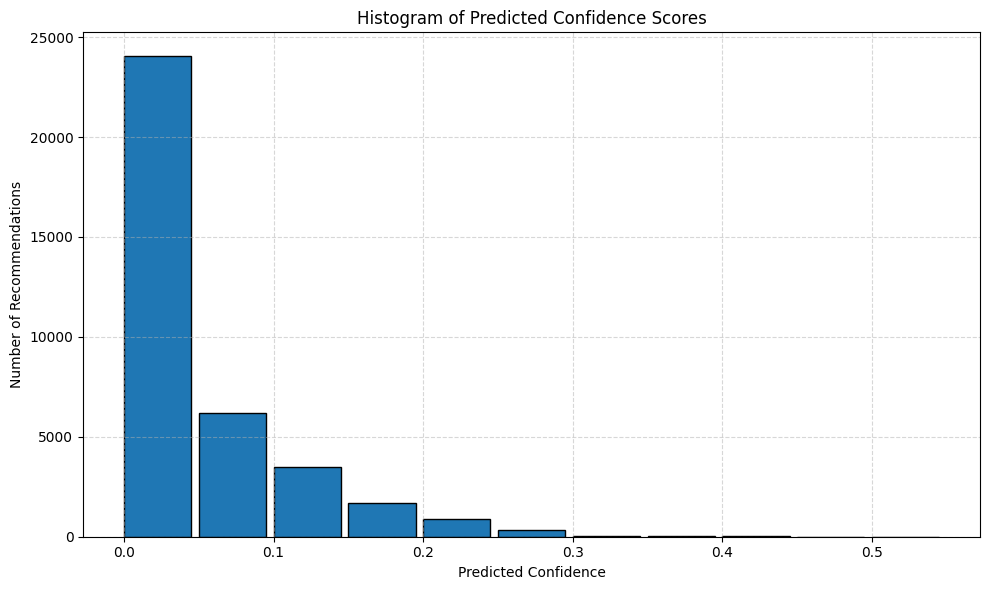

In [0]:
# Plot histogram 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(hist_pd["confidence_bin"], hist_pd["num_predictions"], width=bin_width * 0.9, align="edge", edgecolor="black")

plt.xlabel("Predicted Confidence")
plt.ylabel("Number of Recommendations")
plt.title("Histogram of Predicted Confidence Scores")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


From this histogram, I can see that by far the most recommendations have quite a low predicted confidence (0.05 or less). I assume this is because the recommendations with higer predicted confidence were filtered out when I filtered out the games that members had already played. 

## Conclusion

I built a collaborative recommender system trained on videogame purchase and play duration data. I used the model trained on play duration (which was more accurate) to generate recommendations for games that members had not yet played. Regarding reflections on how I could improve this system further: if I had more time, I would run the grid searches with more hyperparameters, to see if there are other hyperparameter combinations that could improve the accuracy further. I would also try other accuracy evaluation metrics such at Precision@K. This might be a more appropriate metric for a recommender system as it would assess the accuracy of the ranking, rather than how close the predicted value is to the actual value. 

In developing this system, I used ChatGPT at some stages to identify errors in my code when it didn't work. 